In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import scipy.stats as stats

moviefile = pd.read_csv('.\\cleaned_data\\movies_w_2018_cleaned.csv')
tvfile = pd.read_csv('.\\cleaned_data\\tv_series_cleaned.csv')
moviedata = pd.DataFrame(moviefile)
tvdata = pd.DataFrame(tvfile)
moviedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17605 entries, 0 to 17604
Data columns (total 12 columns):
Title          17605 non-null object
Year           17605 non-null int64
Genre          17592 non-null object
Country        17600 non-null object
RT_Ratings     17605 non-null object
Metascore      11827 non-null float64
imdbRating     17605 non-null float64
imdbVotes      17604 non-null object
Type           17605 non-null object
Production     16375 non-null object
RT_Ratings2    17605 non-null int64
imdbRating2    17605 non-null float64
dtypes: float64(3), int64(2), object(7)
memory usage: 1.6+ MB


# Have ratings changed over time?

In [2]:
moviedatayear = moviedata.query("Year>1999").query("Year<2019")

tvdatayear = tvdata.query("Year2>1999").query("Year2<2019")
moviedata.head()

,Title,Year,Genre,Country,RT_Ratings,Metascore,imdbRating,imdbVotes,Type,Production,RT_Ratings2,imdbRating2
0,Toy Story,1995,"Animation, Adventure, Comedy, Family, Fantasy",USA,100%,95.0,8.3,"778,821",movie,Buena Vista,100,83.0
1,Jumanji,1995,"Adventure, Family, Fantasy",USA,53%,39.0,6.9,"264,569",movie,Sony Pictures Home Entertainment,53,69.0
2,Grumpier Old Men,1995,"Comedy, Romance",USA,17%,46.0,6.6,"22,256",movie,Warner Home Video,17,66.0
3,Waiting to Exhale,1995,"Comedy, Drama, Romance",USA,56%,NaN,5.8,"8,613",movie,Twentieth Century Fox Home Entertainment,56,58.0
4,Father of the Bride Part II,1995,"Comedy, Family, Romance",USA,48%,49.0,6.0,"30,949",movie,Disney,48,60.0


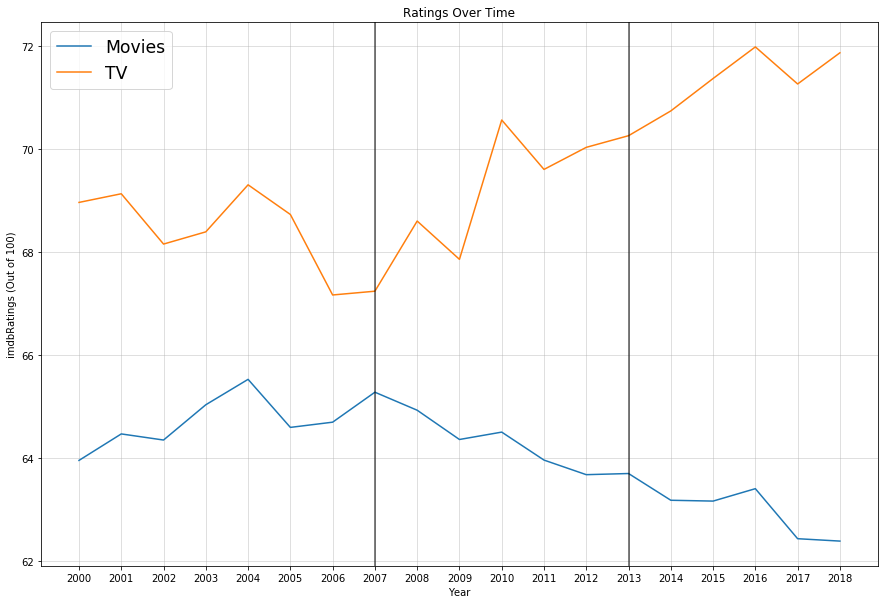

In [3]:
x_axism = moviedatayear.groupby('Year')['Year'].max()
x_axist = tvdatayear.groupby('Year2')['Year2'].max()
rt = moviedatayear.groupby('Year')["RT_Ratings2"].mean()
tv  = tvdatayear.groupby('Year2')["imdbRating2"].mean()
imdb = moviedatayear.groupby('Year')["imdbRating2"].mean()
plt.figure(figsize = (15,10))


labels = ["Movies","TV"]
plt.plot(x_axism, imdb)
plt.plot(x_axist, tv)
plt.xlabel("Year")
plt.ylabel("imdbRatings (Out of 100)")
plt.grid(True,alpha=.5)
plt.xticks(range(2000,2019,1))
plt.legend(labels=labels,fontsize="xx-large")
plt.axvline(2007,linewidth=2, color='k',alpha=.5)
plt.axvline(2013,linewidth=2, color='k',alpha=.5)
plt.title("Ratings Over Time")

plt.savefig('.\\Output\\ratingsovertime.png')
plt.show()

In [4]:
genrefile = pd.read_csv('.\\cleaned_data\\movie_genres_cleaned.csv')
genredata = DataFrame(genrefile)

genreyear = genredata.query("Year>1999")
genres = genreyear.groupby(["Genre","Year"])["imdbRating2"].mean()

genredf = genres.unstack(level=0)
genredf.columns = [x for x in genredf.columns]
genredf.head()

,Action,Animation,Comedy,Documentary,Drama,Fantasy,Horror
Year,,,,,,,
2000,59.327586,65.631579,62.225434,73.032258,65.604396,58.684211,58.750000
2001,60.632353,66.272727,62.083333,73.937500,66.007168,64.189189,57.666667
2002,59.633803,61.555556,60.584795,72.880000,66.509554,59.617647,56.486486
2003,62.366197,68.750000,61.588571,73.368421,67.533865,62.448276,56.026316
2004,64.104478,65.434783,61.602410,71.444444,67.498221,62.135135,57.794872


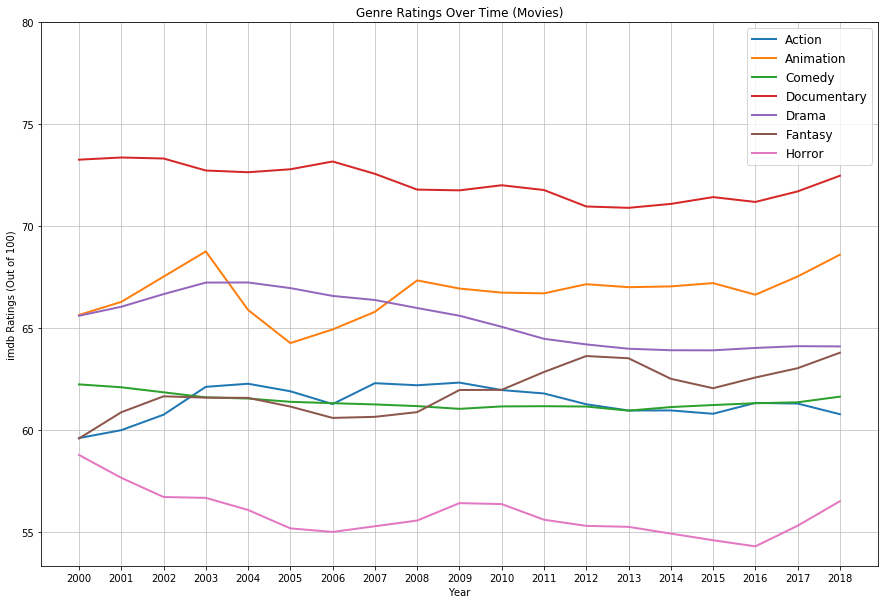

In [5]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

plt.figure(figsize = (15,10))
plt.xticks(range(2000,2019,1))

for column in genredf:
    w = lowess(genredf[column],genredf.index, frac=0.25)
    plt.plot(w[:,0], w[:,1],linewidth=2,label=genredf[column])
    
plt.legend(labels=genredf.columns,loc=1, fontsize="large")
plt.grid(True,alpha=.75)
plt.ylim(top=80)

plt.xlabel("Year")
plt.ylabel("imdb Ratings (Out of 100)")
plt.title("Genre Ratings Over Time (Movies)")

# Save the Figure
plt.savefig('.\\Output\\genreratingsovertime.png')

In [6]:
percentchange = Series(genredf.pct_change(18).iloc[18]*100)

percentchange

Action         1.548846
Animation      4.814889
Comedy        -0.903991
Documentary   -0.355365
Drama         -2.200976
Fantasy        7.871557
Horror        -3.711034
Name: 2018, dtype: float64

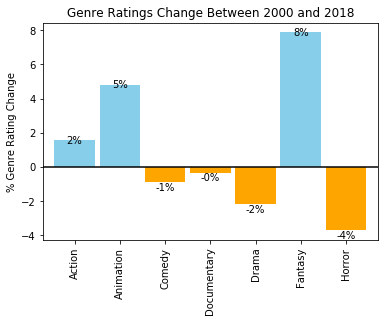

In [7]:
ax = percentchange.plot(kind="bar",title="Genre Ratings Change Between 2000 and 2018",\
                         color = ['orange' if percentchange[r] < 0 else 'skyblue' for r in range(7)],width=.9)
plt.ylabel("% Genre Rating Change")
plt.axhline(y=0, color = 'black') #adds a horizontal line at zero

# Use functions to label the percentages of changes
def add_value_labels(ax):
    for rect in ax.patches:
        # Get X and Y placement of label from rect
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label
        space = 5
        # Vertical alignment for positive values
        va = 'top'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -2
            # Vertically align label at top
            va = 'bottom'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}%".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va,                     # Vertically align label differently for
            color = "black")        # positive and negative values.

# Call the function above
add_value_labels(ax)

# Save the Figure
plt.savefig('.\\Output\\genreratingchangebar.png')

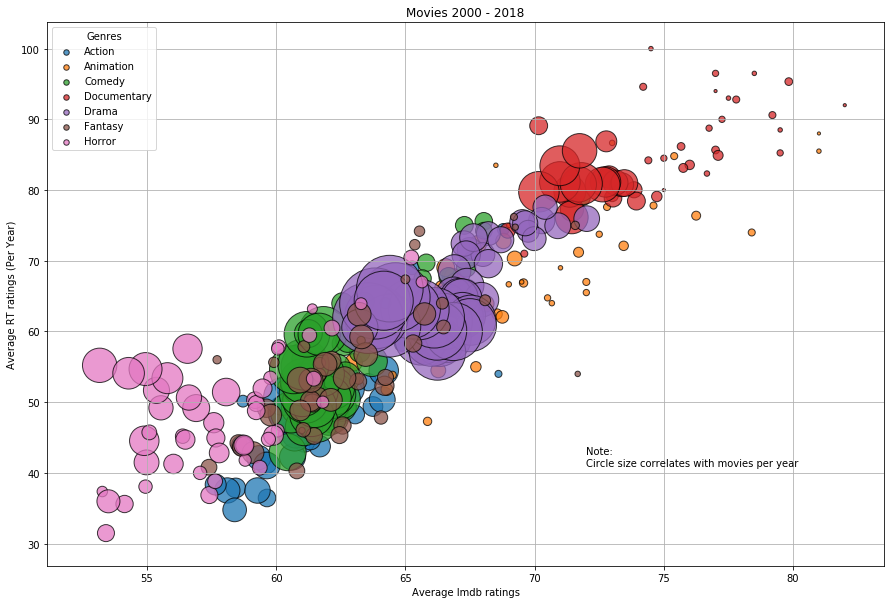

In [8]:
#Set up for loop
#Counter is used to move sequentially through the lists
plt.figure(figsize = (15,10))
genres = ['Action','Animation','Comedy','Documentary','Drama','Fantasy','Horror']
counter = 0

for genre in genres:
    plt.scatter(genredata.loc[genredata["Genre"]==genres[counter]].groupby("Year")["imdbRating2"].mean(),\
                genredata.loc[genredata["Genre"]==genres[counter]].groupby("Year")["RT_Ratings2"].mean(),\
                s=genredata.loc[genredata["Genre"]==genres[counter]].groupby("Year")["Title"].count()*10,\
                marker="o",alpha=.75,edgecolors ="k",label=genres[counter])
    counter +=1

# Incorporate the other graph properties
plt.title("Movies 2000 - 2018")
plt.ylabel("Average RT ratings (Per Year)")
plt.xlabel("Average Imdb ratings")
plt.grid(True)

# Create a legend
lgnd = plt.legend(loc=0,title="Genres")

#The below makes the legend bubbles all the same size
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
lgnd.legendHandles[3]._sizes = [30]
lgnd.legendHandles[4]._sizes = [30]
lgnd.legendHandles[5]._sizes = [30]
lgnd.legendHandles[6]._sizes = [30]

#Incorporate a text label regarding circle size
#Note:This does not show if using %Matplotlib Notebook
plt.text(72,41,"Note:\nCircle size correlates with movies per year")

# Save Figure
plt.savefig('.\\Output\\ratingbubble.png')

# Has movie and TV production changed over the same time period?

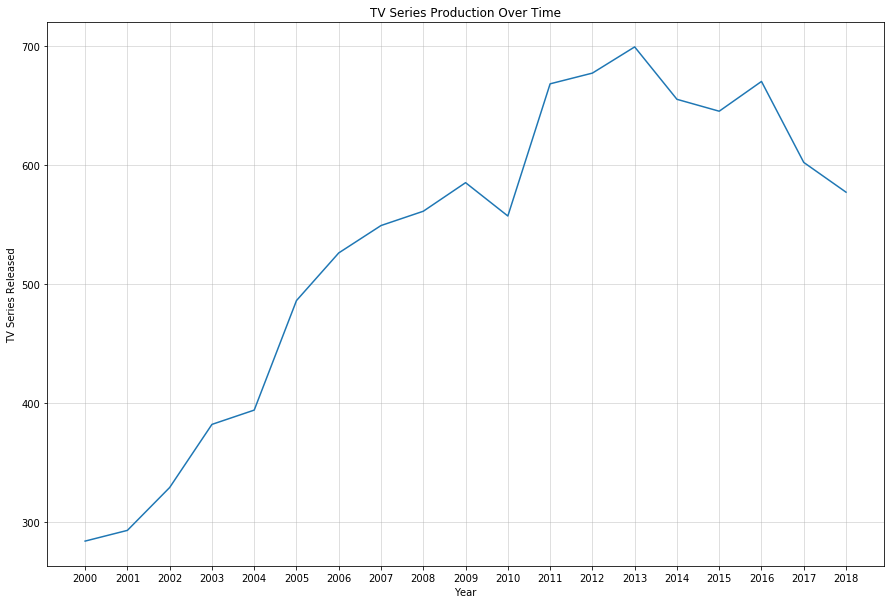

In [9]:
plt.figure(figsize = (15,10))

plt.plot(tvdatayear.groupby("Year2")["Year2"].max(),tvdatayear.groupby("Year2")["Title"].count())
plt.xlabel("Year")
plt.ylabel("TV Series Released")

plt.grid(True,alpha=.5)
plt.xticks(range(2000,2019,1))
plt.title("TV Series Production Over Time")

plt.savefig('.\\Output\\tvproducedovertime.png')
plt.show()

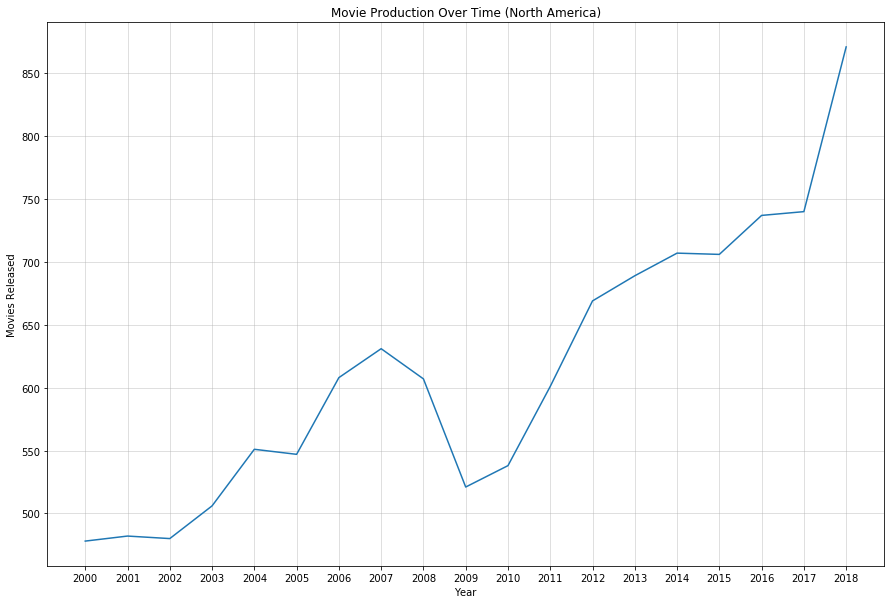

In [10]:
#Source https://www.statista.com/statistics/187122/movie-releases-in-north-america-since-2001/

movieprodfile = pd.read_csv('.\\cleaned_data\\movie-releases.csv')
movieproddata = pd.DataFrame(movieprodfile)

plt.figure(figsize = (15,10))

plt.plot(movieproddata["Year"],movieproddata["Number of movies released"])
plt.xlabel("Year")
plt.ylabel("Movies Released")

plt.grid(True,alpha=.5)
plt.xticks(range(2000,2019,1))
plt.title("Movie Production Over Time (North America)")

plt.savefig('.\\Output\\moviesproducedovertime.png')
plt.show()

In [11]:
genreper = genreyear.groupby(["Genre","Year"])["Title"].count() / genreyear.groupby(["Year"])["Title"].count()

genreperdf = genreper.unstack(level=0)
genreperdf.columns = [x for x in genredf.columns]

genreperdf.head()

,Action,Animation,Comedy,Documentary,Drama,Fantasy,Horror
Year,,,,,,,
2000,0.091772,0.030063,0.273734,0.049051,0.431962,0.060127,0.063291
2001,0.104455,0.033794,0.276498,0.049155,0.428571,0.056836,0.050691
2002,0.102158,0.025899,0.246043,0.071942,0.451799,0.048921,0.053237
2003,0.111460,0.025118,0.274725,0.089482,0.394035,0.045526,0.059655
2004,0.100450,0.034483,0.248876,0.080960,0.421289,0.055472,0.058471


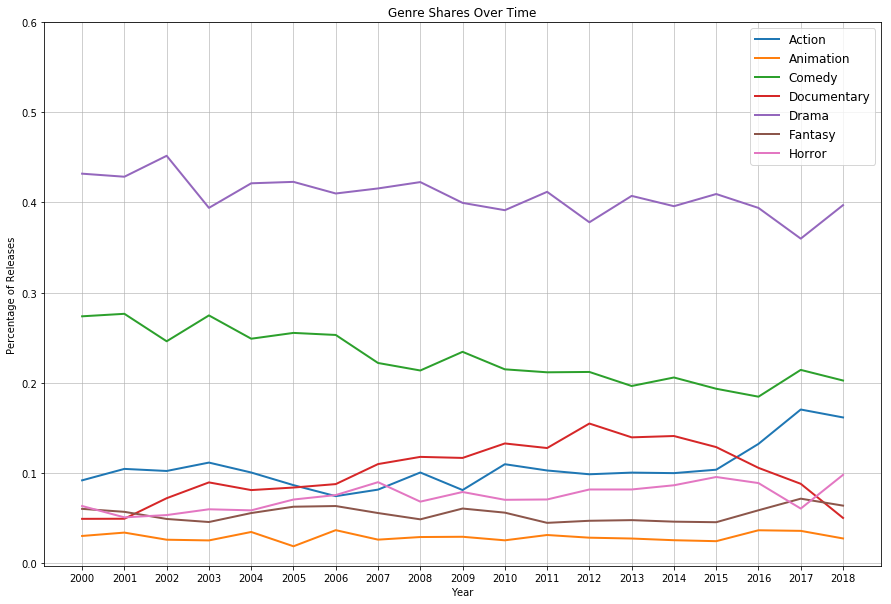

In [12]:
plt.figure(figsize = (15,10))
plt.xticks(range(2000,2019,1))

for column in genreperdf:
    plt.plot(genreperdf.index,genreperdf[column],linewidth=2,label=genreperdf[column])  
    
plt.legend(labels=genreperdf.columns,loc=1, fontsize="large")    
plt.grid(True,alpha=.75)
plt.ylim(top=.6)

plt.xlabel("Year")
plt.ylabel("Percentage of Releases")
plt.title("Genre Shares Over Time")

# Save the Figure
plt.savefig('.\\Output\\genresharesovertime.png')
plt.show()

In [13]:
percentchange = Series(genreperdf.pct_change(18).iloc[18]*100)

percentchange

Action         76.030756
Animation      -9.179091
Comedy        -26.022082
Documentary     2.051451
Drama          -8.084028
Fantasy         5.957727
Horror         54.584755
Name: 2018, dtype: float64

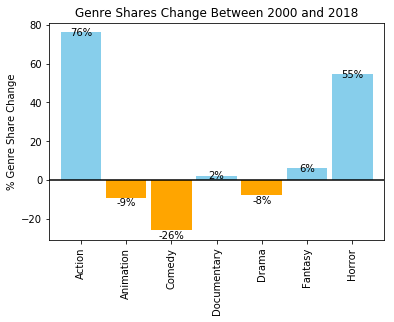

In [14]:
ax = percentchange.plot(kind="bar",title="Genre Shares Change Between 2000 and 2018",\
                         color = ['orange' if percentchange[r] < 0 else 'skyblue' for r in range(7)],width=.9)
plt.ylabel("% Genre Share Change")
plt.axhline(y=0, color = 'black') #adds a horizontal line at zero

add_value_labels(ax)

# Save the Figure
plt.savefig('.\\Output\\genresharechangebar.png')

In [15]:
tv_shows = pd.read_csv(".\\cleaned_data\\tv_shows.csv")
tv_shows= tv_shows.rename(index=str, columns={"Basic cable*": "cable", "Broadcast**" : "broadcast", \
                                    "Online services***": "online", "Pay cable": "pay_cable"}, )
tv_shows.head()

,Year,cable,broadcast,online,pay_cable
0,2009,66,122,1,21
1,2010,74,113,4,25
2,2011,111,116,6,33
3,2012,125,119,15,29
4,2013,161,131,24,33


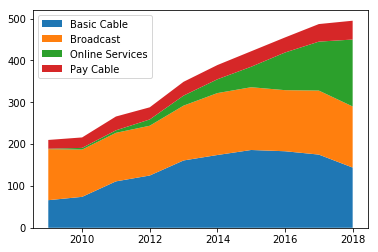

In [16]:
year = tv_shows['Year']
cable = tv_shows['cable']
broadcast = tv_shows['broadcast']
online = tv_shows['online']
pay_cable = tv_shows['pay_cable']

y = np.vstack([cable, broadcast, online, pay_cable])

labels = ["Basic Cable", "Broadcast", "Online Services", "Pay Cable" ]

fig, ax = plt.subplots()
ax.stackplot(year, cable, broadcast, online,pay_cable, labels=labels)
ax.legend(loc='upper left')
plt.savefig('.\\Output\\marketshare.png')
plt.show()

# What is the trend for box office revenue over the same time period?

In [17]:
#Revenue Source:https://www.the-numbers.com/market/
#Population Source: https://www.multpl.com/united-states-population/table/by-year
revenuefile = pd.read_csv('.\\cleaned_data\\box_office_w_pop.csv')
revdata = DataFrame(revenuefile)
revdata.head()

,Year,Tickets Sold,Total Box Office,Total Inflation Adjusted Box Office,Average Ticket Price,US Population
0,2018,1343070792,12047347741,12047347867,8.97,328030000
1,2017,1225524720,10992959545,10992959664,8.97,325720000
2,2016,1291731663,11259213129,11586833074,8.65,323410000
3,2015,1289902170,11155102984,11570422578,8.43,321040000
4,2014,1257399140,10272966196,11278870299,8.17,318620000


In [18]:
revdata["Avg. Tickets Per Person"] = revdata["Tickets Sold"] / revdata["US Population"] 
revdata.head()

,Year,Tickets Sold,Total Box Office,Total Inflation Adjusted Box Office,Average Ticket Price,US Population,Avg. Tickets Per Person
0,2018,1343070792,12047347741,12047347867,8.97,328030000,4.094354
1,2017,1225524720,10992959545,10992959664,8.97,325720000,3.762510
2,2016,1291731663,11259213129,11586833074,8.65,323410000,3.994099
3,2015,1289902170,11155102984,11570422578,8.43,321040000,4.017886
4,2014,1257399140,10272966196,11278870299,8.17,318620000,3.946391


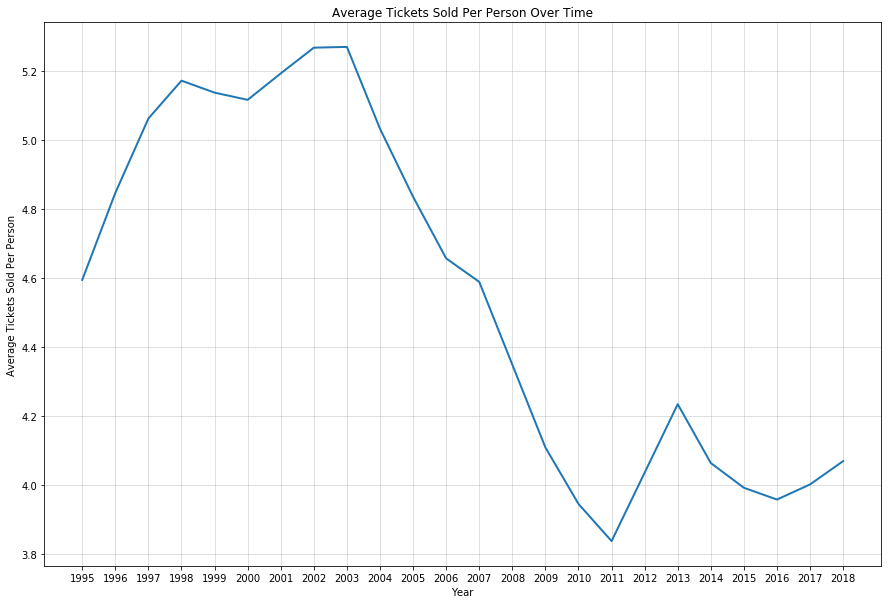

In [19]:
plt.figure(figsize = (15,10))

w = lowess(revdata["Avg. Tickets Per Person"],revdata["Year"], frac=0.20)
plt.plot(w[:,0], w[:,1],linewidth=2)

plt.xlabel("Year")
plt.ylabel("Average Tickets Sold Per Person")

plt.grid(True,alpha=.5)
plt.xticks(range(1995,2019,1))
plt.title("Average Tickets Sold Per Person Over Time")

plt.savefig('.\\Output\\ticketssoldovertime.png')
plt.show()

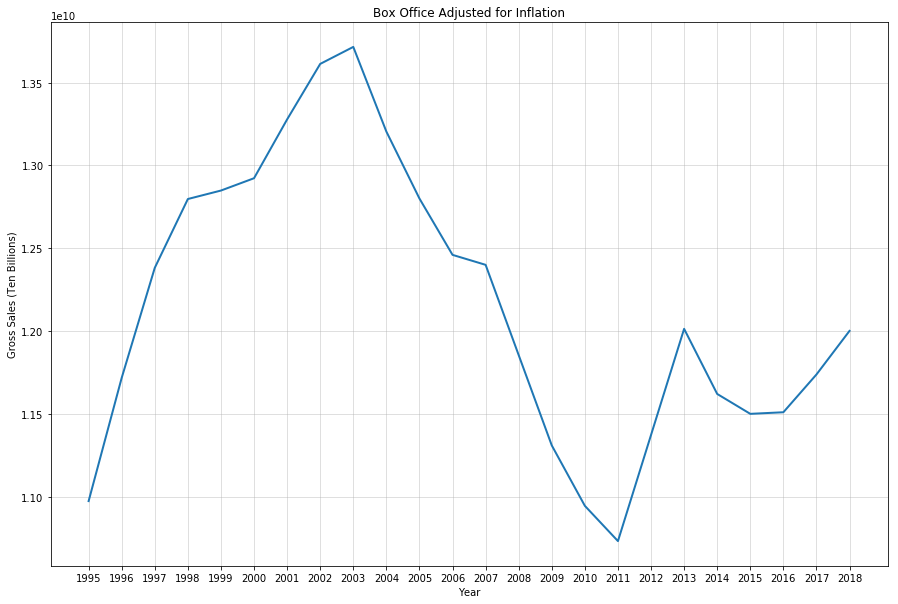

In [20]:
plt.figure(figsize = (15,10))

w = lowess(revdata["Total Inflation Adjusted Box Office"],revdata["Year"], frac=0.20)
plt.plot(w[:,0], w[:,1],linewidth=2)

plt.xlabel("Year")
plt.ylabel("Gross Sales (Ten Billions)")

plt.grid(True,alpha=.5)
plt.xticks(range(1995,2019,1))
plt.title("Box Office Adjusted for Inflation")

plt.savefig('.\\Output\\boxofficeovertime.png')
plt.show()

# T-Test

In [21]:
file_name=".\\cleaned_data\\movies_w_2018_cleaned.csv"
all_movies_df = pd.read_csv(file_name,encoding="UTF-8",low_memory=False)
all_movies_df = all_movies_df[all_movies_df["Year"] >= 2000]


file_name1= ".\\cleaned_data\\tv_series_cleaned.csv"
all_tv_df = pd.read_csv(file_name1,encoding="UTF-8",low_memory=False)
all_tv_df  = all_tv_df [all_tv_df ["Year2"] >= 2000]
all_tv_df.head()

,Title,Year,Genre,Country,imdbRating,imdbVotes,imdbID,Year2,imdbRating2
1391,Gensomaden Saiyuki,2000–2001,"Animation, Action, Adventure",Japan,7.7,142,tt0111056,2000.0,77.0
2042,Chto skazal pokoynik,2000–,"Adventure, Crime, Comedy","Russia, Poland, France, Germany, Denmark",6.7,86,tt0154065,2000.0,67.0
2132,MI-5,2002–2011,"Drama, Thriller",UK,8.3,"12,867",tt0160904,2002.0,83.0
2234,Randall & Hopkirk (Deceased),2000–2001,"Comedy, Crime, Fantasy",UK,6.7,484,tt0167701,2000.0,67.0
2372,Don Matteo,2000–,"Comedy, Crime, Drama",Italy,6.7,684,tt0178132,2000.0,67.0


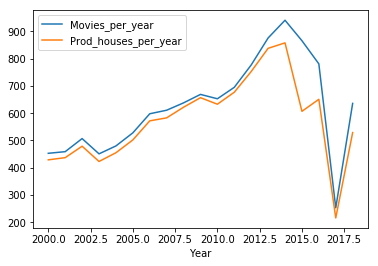

<Figure size 432x288 with 0 Axes>

In [22]:
gb_all_movies_df= all_movies_df.groupby("Year")
movies_per_year = gb_all_movies_df["Year"].count()
prod_per_year = gb_all_movies_df["Production"].count()

summary_df = pd.DataFrame({"Movies_per_year" : movies_per_year , "Prod_houses_per_year" : prod_per_year})

per_year_chart = summary_df.plot(kind="line", label=True)
#order_status_chart.set_xlabel("ORDER STATUS PER YEAR")
#order_status_chart.set_ylabel("Counts")
#Saving the Graph image
plt.savefig(".\\Output\\bar_graph.png")
plt.show()
plt.tight_layout()

In [23]:
pop1 = all_movies_df[all_movies_df["Year"] >= 2000]
pop1.reset_index(inplace= True)
loc1=pop1.imdbRating2.mean()
#sd1 = statistics.stdev(pop1.imdbRating2)
#print(sd1)
#print(len(pop1.imdbRating2))
#print("pop1 mean value :" + str(pop1.imdbRating2.mean()))
#print(loc1)
pop2 = all_tv_df[all_tv_df["Year2"] >= 2000]
pop2.reset_index(inplace= True)
loc2=pop2.imdbRating2.mean()
#print("pop2 mean value :" + str(pop2.imdbRating2.mean()))
#print(loc2)
#sd2 = statistics.stdev(pop2.imdbRating2)
#print(sd2)

In [24]:
diff = pop1['imdbRating2'] - pop2['imdbRating2']

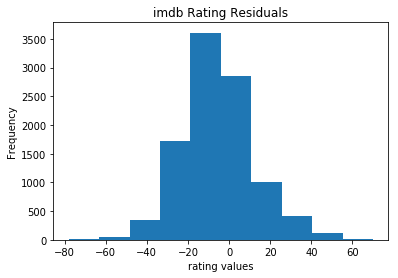

In [25]:
#Normality test - if in bell curve format no far deviations exsists. 

diff.plot(kind= "hist", title= "imdb Rating Residuals")
plt.xlabel("rating values")
plt.savefig(".\\Output\\xyz.png")

In [26]:
#Independent ttest 
stats.ttest_ind(pop1.imdbRating2,pop2.imdbRating2,equal_var=False)

Ttest_indResult(statistic=-34.153000378921746, pvalue=9.497974203392669e-248)